In [1]:
import pickle as pkl
from scipy import optimize, sparse
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq, inv
import scipy as sp
from scipy import sparse
from scipy import optimize
import scipy.stats as stats
import math
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [2]:
import corner
import emcee
from tabulate import tabulate
import time

## XP spectra:  
*[how to access Gaia XP spectra]: (https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products#datalink_jntb_get_all_prods)  

## APOGEE labels (Teff, Log g):  
* [labels: APOGEE DR17 catalog]. (https://www.sdss4.org/dr17/irspec/spectro_data/).   
[data model] : (https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStarLite.html)

**Problem 1:**

**get data

In [3]:

%config InlineBackend.figure_format = "retina"
%matplotlib inline
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np


import pickle

data_dir = "C:/Users/jessm/Documents/NYU/2nd Year/Data Analysis/"
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"


with open(data_dir+tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(data_dir+val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of traing set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])



Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of traing set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


In [4]:

bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']

teff_tr = data_tr['labels'][:,0]

bp_val, rp_val = data_val['bp_coef'], data_val['rp_coef']

teff_val = data_val['labels'][:,0]

**data visualization (training set as example) 

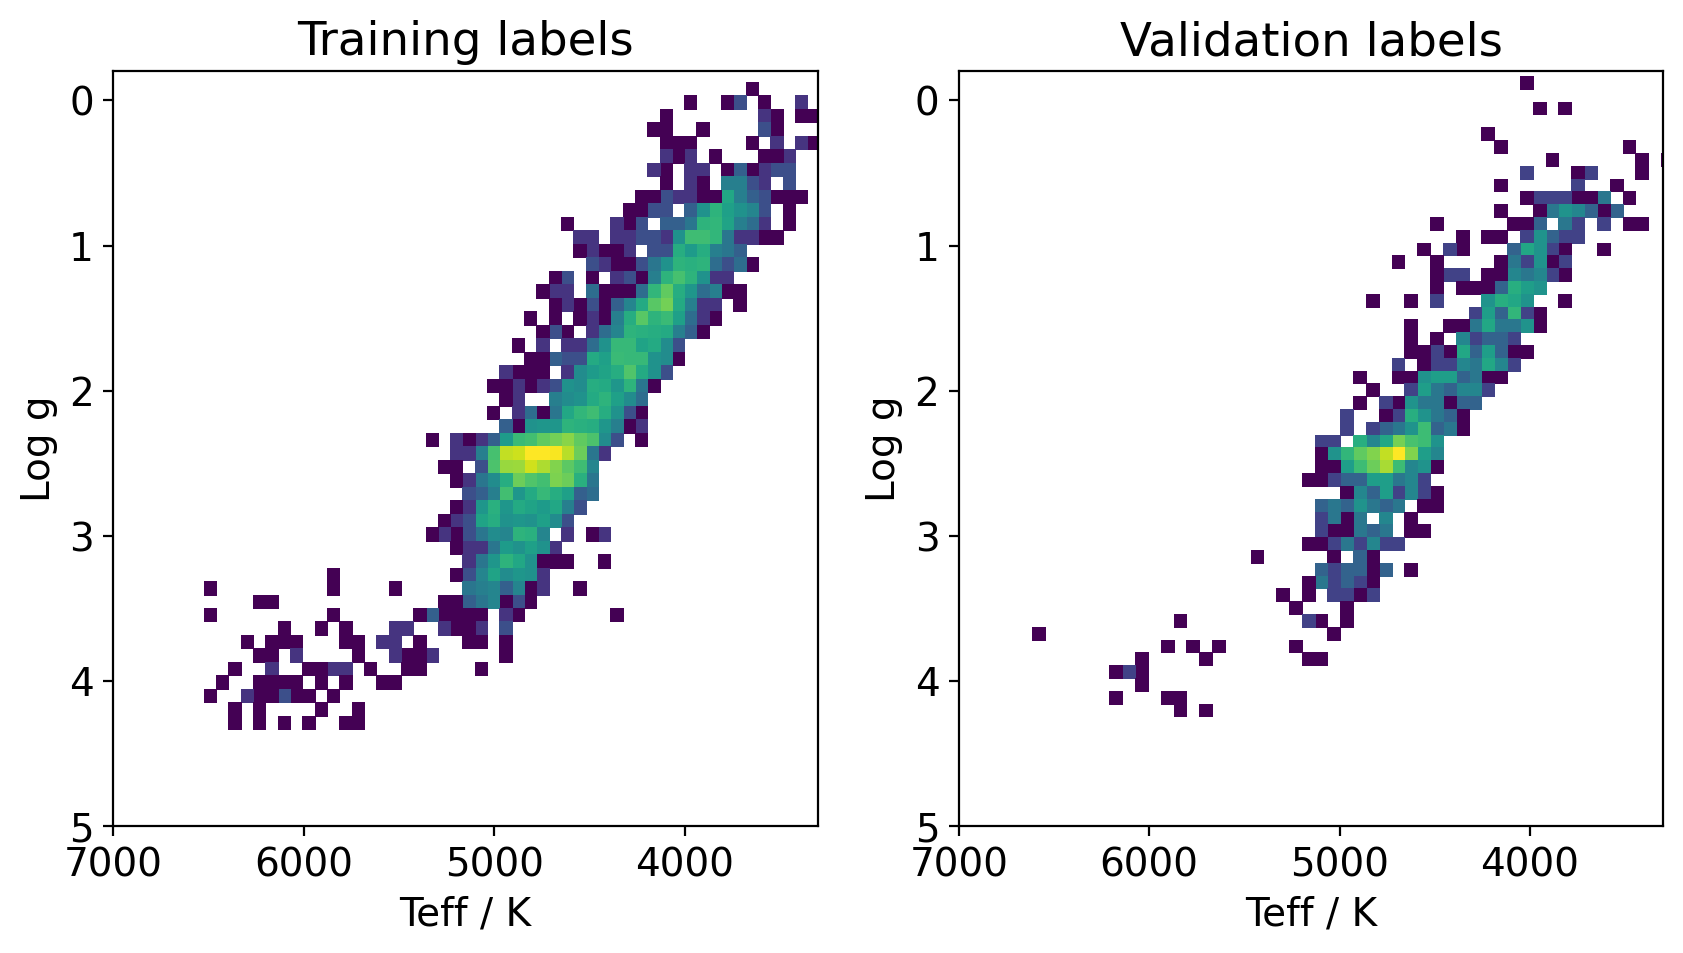

In [5]:
# Teff - Log g plot

fig, axs = plt.subplots(1,2,figsize=(10,5))


for i, ax in enumerate(axs.ravel()):

    
    if i==0:
        ax.hist2d(
        data_tr['labels'][:,0], data_tr['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Training labels");
    else:
        ax.hist2d(
        data_val['labels'][:,0], data_val['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Validation labels");
        
    ax.set_xlim([7000, 3300]);
    ax.set_ylim([5, -0.2]);
    ax.set_xlabel("Teff / K");
    ax.set_ylabel("Log g");


**show bp and rp coefficients

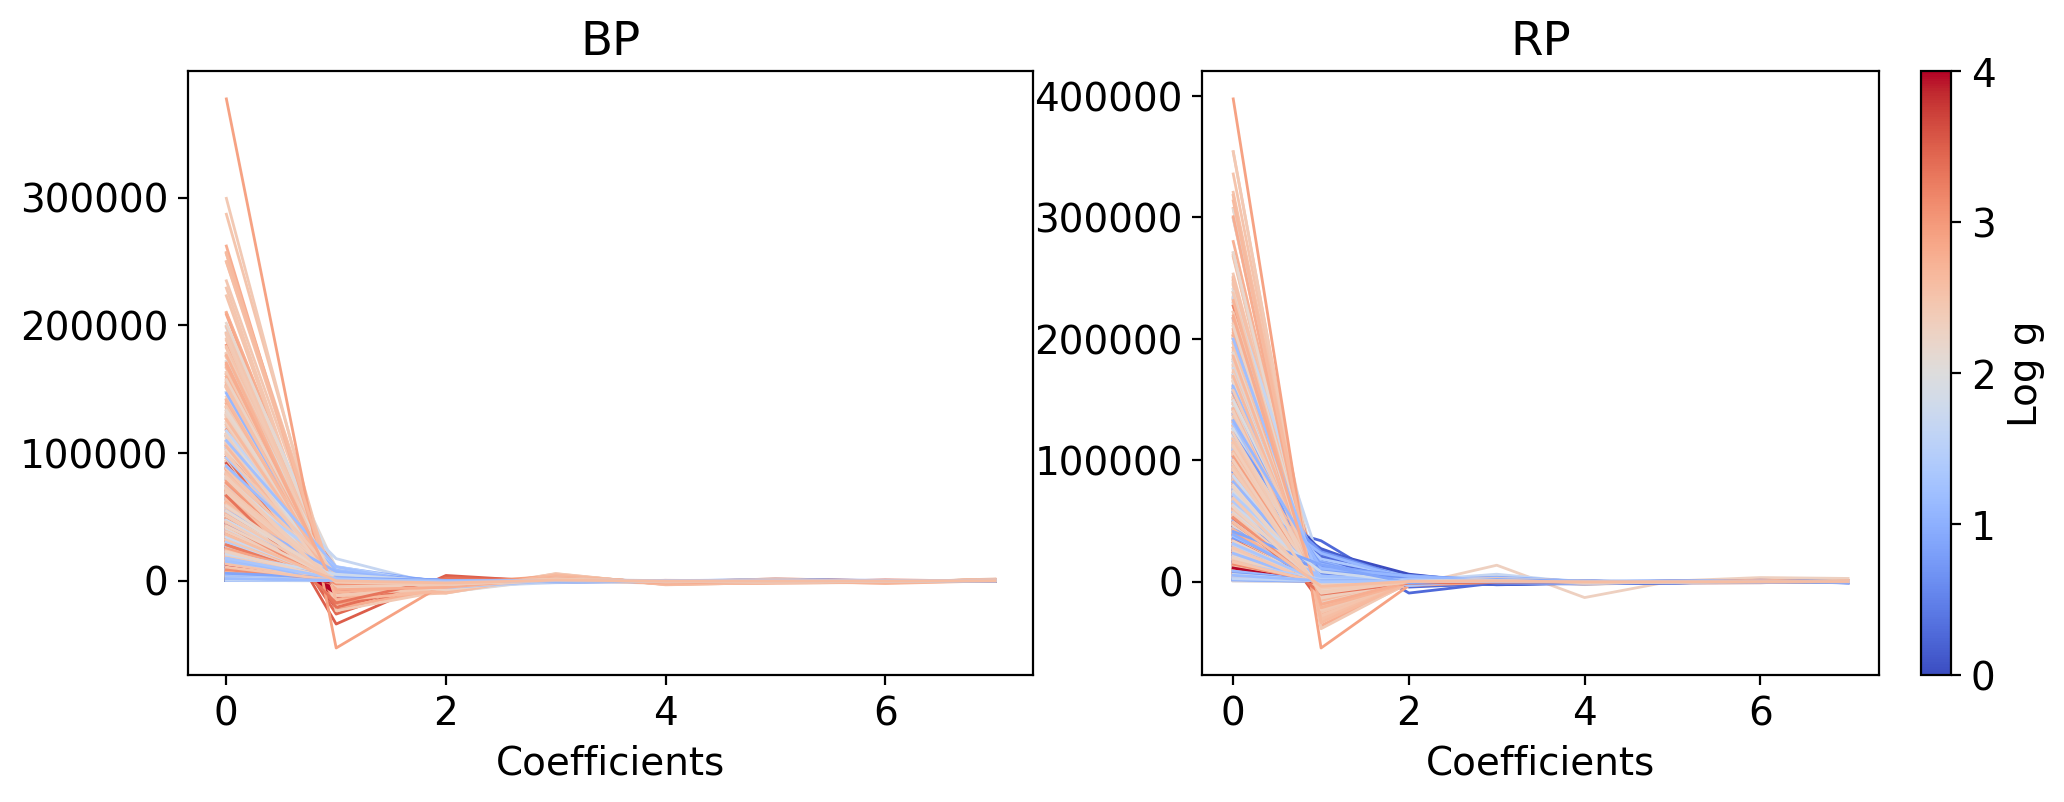

In [6]:
#first eight coefficients color coded by Logg

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0,vmax=4)
colors_train_logg = [cmap(norm(_)) for _ in data_tr['labels'][:,1]]

for i,idx in enumerate(range(len(data_tr['labels']))):
    
    xx = np.arange(8)
    ax1.plot(
        xx, data_tr['bp_coef'][idx,:8],lw=1,
        c=colors_train_logg[i]
    )
    ax2.plot(
        xx, data_tr['rp_coef'][idx,:8],lw=1,
        c=colors_train_logg[i]
    )
    
ax1.set_title("BP");
ax2.set_title("RP");

for ax in axs.ravel():
    ax.set_xlabel("index");
    ax.set_xlabel("Coefficients");
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Log g")


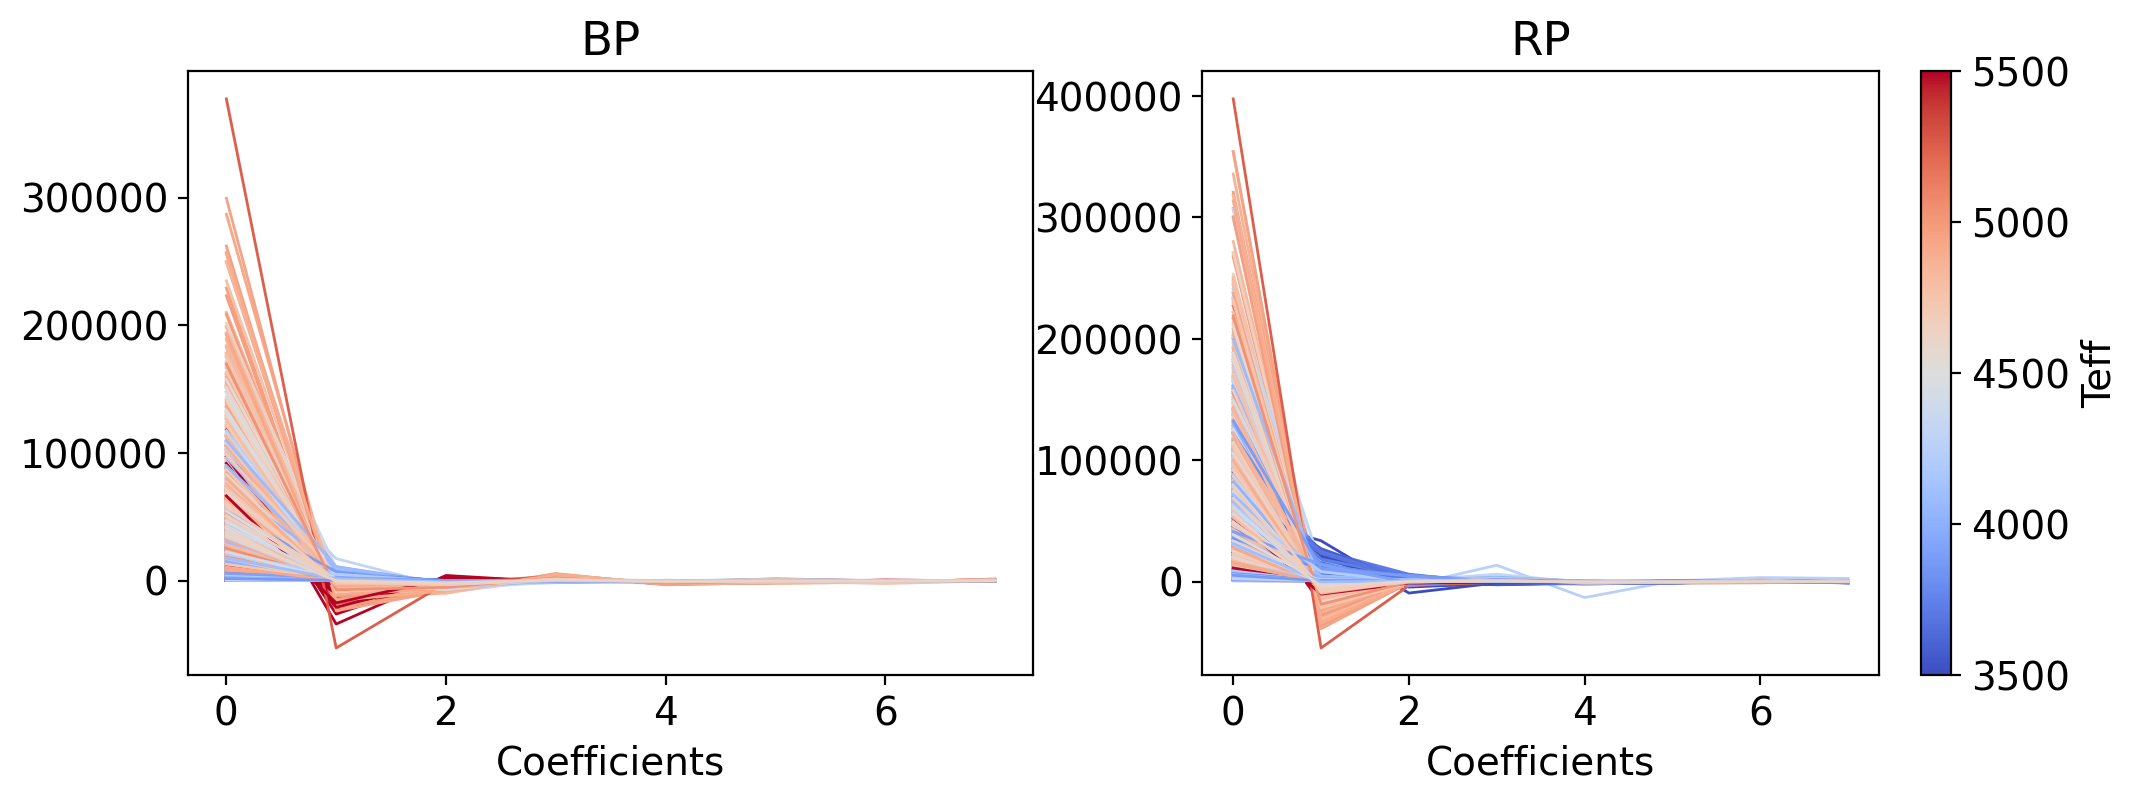

In [7]:
#first eight coefficients color coded by Teff

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=3500, vmax=5500)
colors_train_teff = [cmap(norm(_)) for _ in data_tr['labels'][:,0]]

for i,idx in enumerate(range(len(data_tr['labels']))):
    
    xx = np.arange(8)
    ax1.plot(
        xx, data_tr['bp_coef'][idx,:8],lw=1,
        c=colors_train_teff[i]
    )
    ax2.plot(
        xx, data_tr['rp_coef'][idx,:8],lw=1,
        c=colors_train_teff[i]
    )
    
ax1.set_title("BP");
ax2.set_title("RP");

for ax in axs.ravel():
    ax.set_xlabel("index");
    ax.set_xlabel("Coefficients");
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Teff")


**dimensionality reduction**
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project xp coefficients to a lower dimensional space

In [8]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
x_pca = pca.fit_transform(data_tr['bp_coef'])
print(x_pca.shape)

(4000, 2)


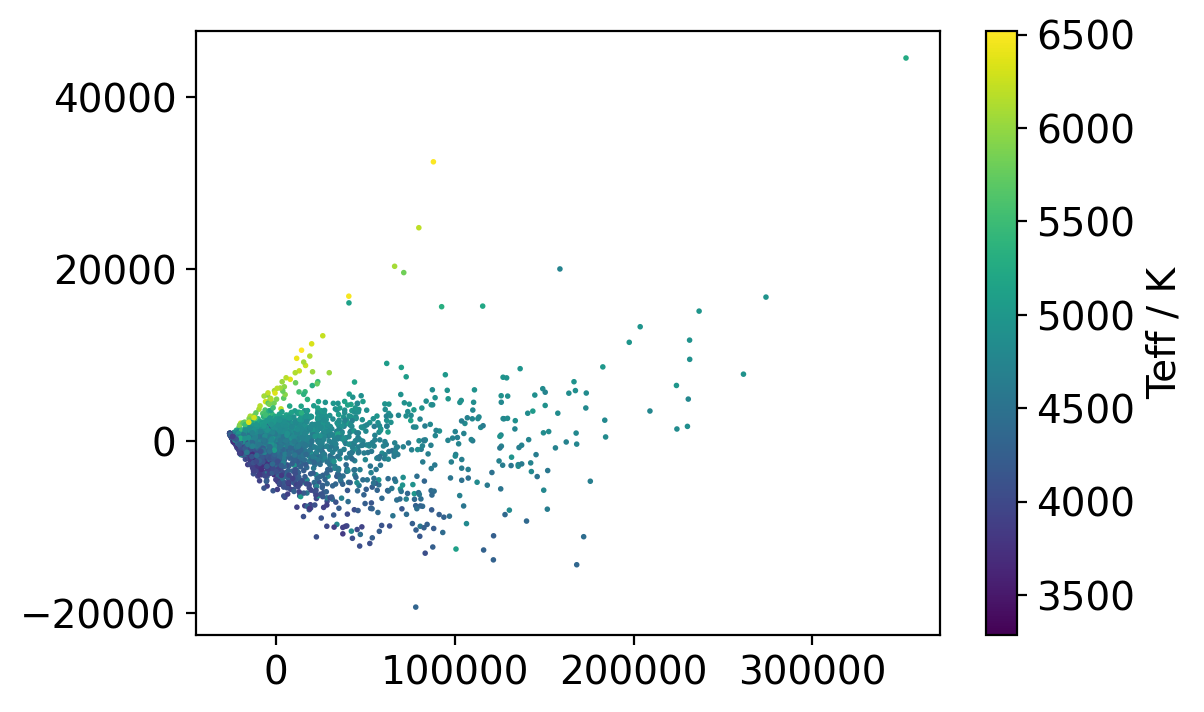

In [9]:
img = plt.scatter(x_pca[:,0], x_pca[:,1], s=1, c=data_tr['labels'][:,0]) 
clb = plt.colorbar(img, label="Teff / K")

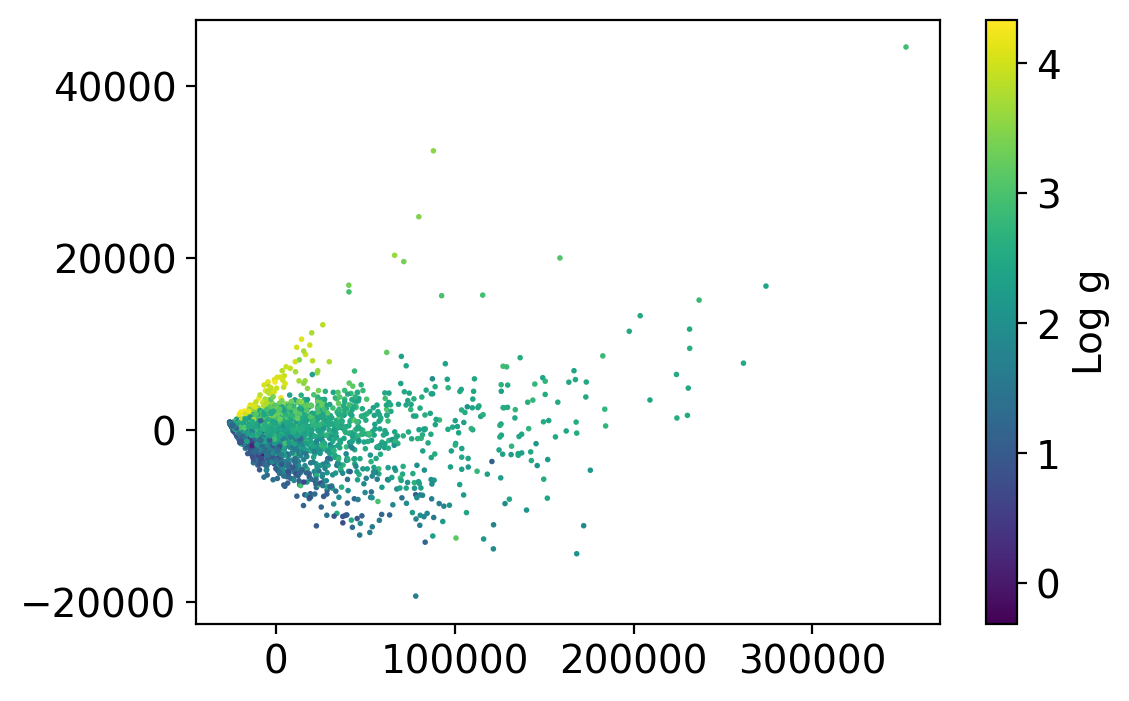

In [10]:
img = plt.scatter(x_pca[:,0], x_pca[:,1], s=1, c=data_tr['labels'][:,1]) 
clb = plt.colorbar(img, label="Log g")

**Problem 1:** Take the Gaia XP data given to you by Jiadong Li. It consists of a set of ESA Gaia Mission BP/RP spectral coefficients, and a set of labels from SDSS-IV APOGEE. These are real data, people, and a real problem. Use linear regression to learn a function that takes as input the BP and RP spectral coefficients and delivers as output the label TEFF, which is the effective temperature of the stars. Instead of using the BP/RP coefficients right out of the box, consider dividing all BP & RP coefficients by the first (zeroth) component of the RP coefficients. Don’t forget to include the number 1 as a regressor (the constant term). Train on the training set and use the validation set to assess your accuracy (RMS maybe or median absolute deviation). Ask questions of Hogg and Jiadong, who know these data well!

In [11]:
from sklearn.linear_model import LinearRegression

print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of training set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

#bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']
#teff_tr = data_tr['labels'][:,0]

bp_tr_mod= bp_tr/data_tr['rp_coef'][0]
rp_tr_mod= rp_tr/data_tr['rp_coef'][0]

bp_val_mod= bp_val/data_val['rp_coef'][0]
rp_val_mod= rp_val/data_val['rp_coef'][0]

ones= np.ones(len(bp_tr_mod[0:]))


Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of training set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


In [12]:
x_train = np.column_stack((bp_tr_mod, rp_tr_mod))
y_train = teff_tr
print(x_train.shape, y_train.shape)

x_val = np.column_stack((bp_val_mod, rp_val_mod))
y_val = teff_val

print(x_val.shape, y_val.shape)

(4000, 110) (4000,)
(1000, 110) (1000,)


In [13]:
# Create linear regression object and Train the model using the training sets

model = LinearRegression().fit(x_train, y_train)

r_sq = model.score(x_train, y_train)
print(f"coefficient of determination for training: {r_sq}")

print(f"intercept: {model.intercept_}")

#print(f"coefficients: {model.coef_}")

coefficient of determination for training: 0.5728659278099214
intercept: 4429.437919622484


In [14]:
# Make predictions using the testing set
y_pred = model.predict(x_val)

# The coefficients
#print("Coefficients: \n", model.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred))

Mean squared error: 200876605.90
Coefficient of determination: -1107.99


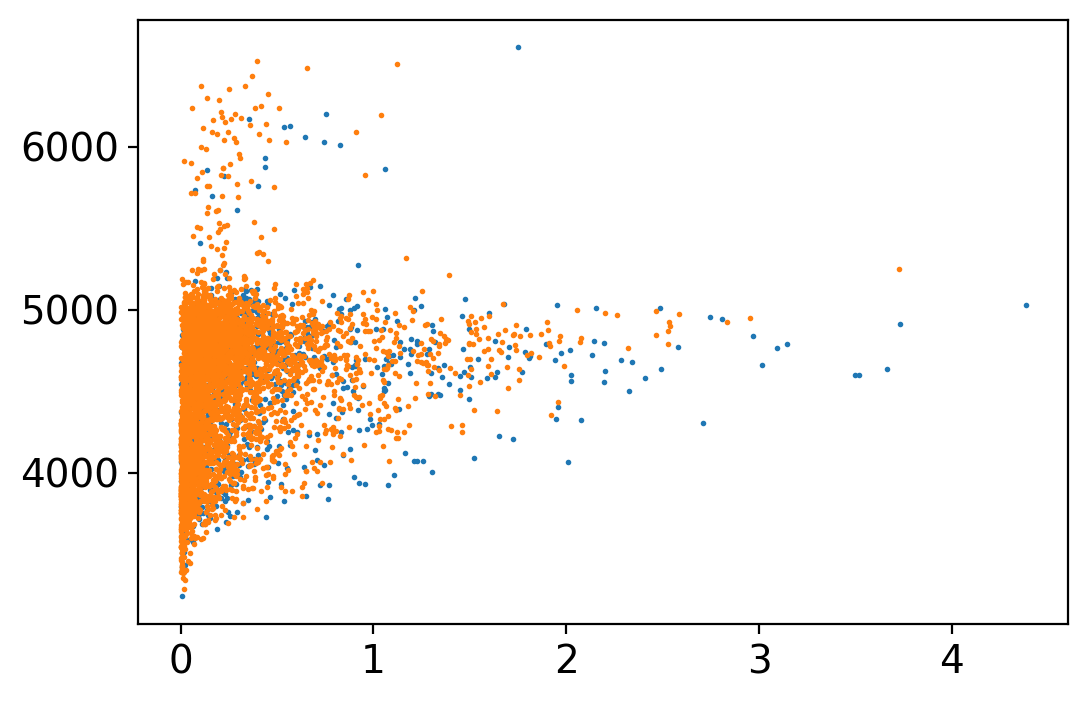

In [15]:
plt.scatter(x_val[:,0], y_val, s=1)
plt.scatter(x_train[:,0], y_train, s=1)

(-100.0, 10000.0)

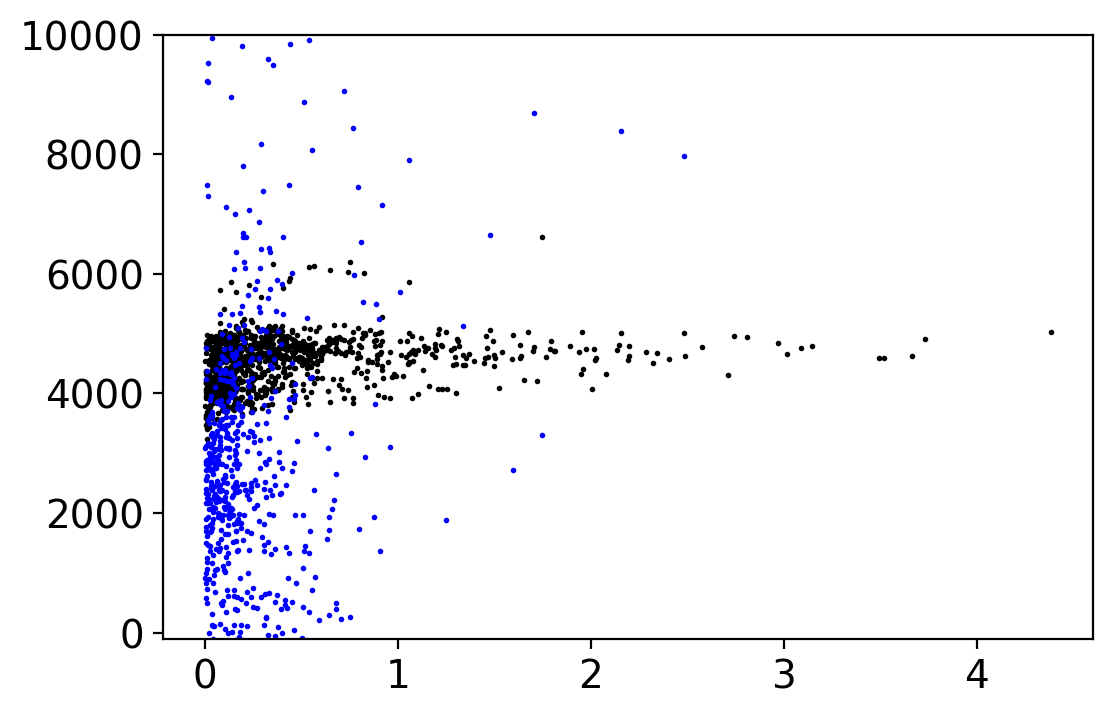

In [16]:
# Plot outputs
#plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.scatter(x_val[:,0], y_val, s=1, color="black")
#plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.scatter(x_val[:,0], y_pred, color="blue", s=1)
plt.ylim(-100, 10000)

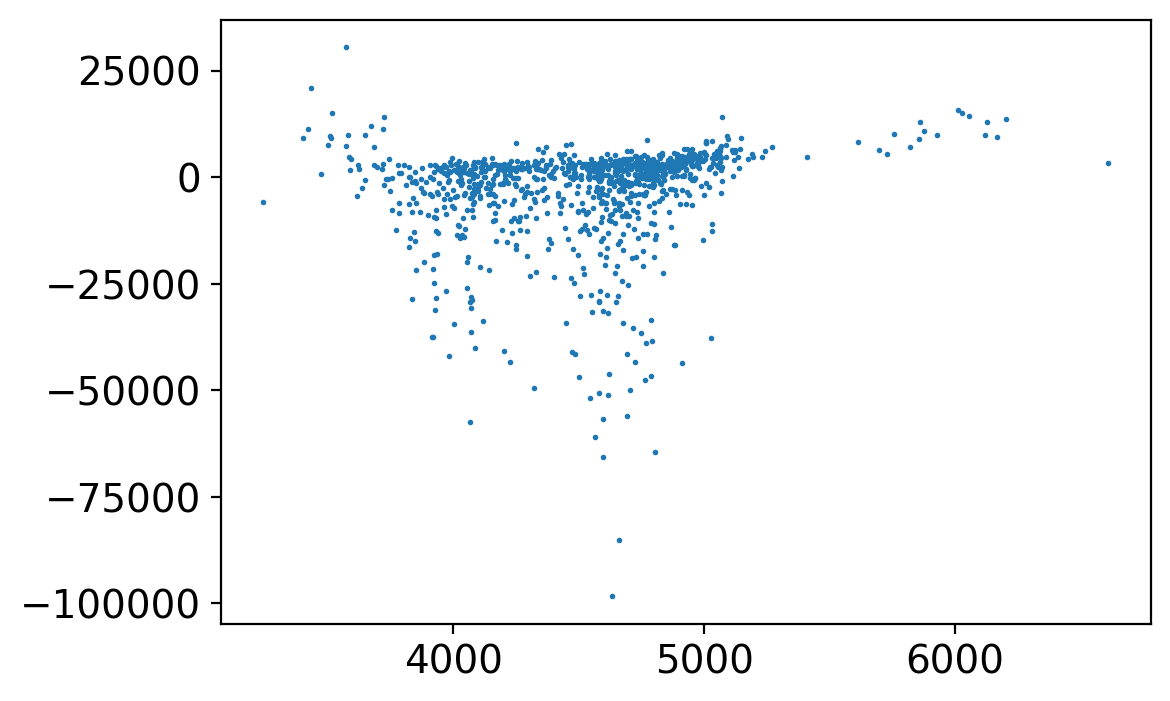

In [17]:
plt.scatter(y_val, y_pred, s=1)

**Problem 2:** Now consider only the RP spectral coefficients. Make a linear model to predict TEFF. Then make all quadratic combinations of the RP coefficients and make a linear model of the linear and quadratic combinations to predict TEFF. Can you afford to do cubic too? Once again, divide the coefficients by RP[0] to start. Once again, don’t forget to include the constant term. Train on the training set and use the validation set to assess your accuracy.

In [18]:
x_train_rp = rp_tr_mod
y_train = teff_tr

x_val_rp = rp_val_mod
y_val = teff_val

print(x_train_rp.shape, y_train.shape)
print(x_val_rp.shape, y_val.shape)

(4000, 55) (4000,)
(1000, 55) (1000,)


In [19]:
# Create linear regression object and Train the model using the training sets

model = LinearRegression().fit(x_train_rp, y_train)

r_sq = model.score(x_train_rp, y_train)
print(f"coefficient of determination for training: {r_sq}")

print(f"intercept: {model.intercept_}")

#print(f"coefficients: {model.coef_}")

# Make predictions using the testing set
y_pred = model.predict(x_val_rp)

# The coefficients
#print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred))



coefficient of determination for training: 0.4877052384745194
intercept: 4467.594383922727
Mean squared error: 18309643.74
Coefficient of determination: -100.08


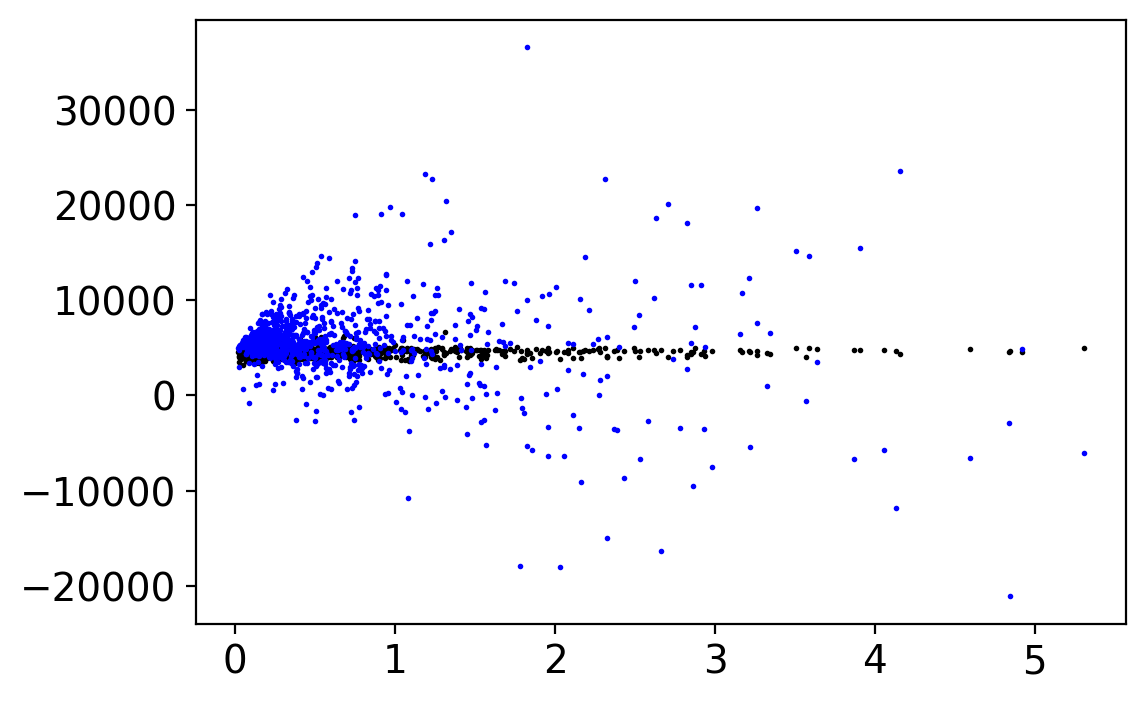

In [20]:
# Plot outputs
plt.scatter(x_val_rp[:,0], y_val, s=1, color="black")
#plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.scatter(x_val_rp[:,0], y_pred, color="blue", s=1)

#thats not horrible

In [21]:
from sklearn.preprocessing import PolynomialFeatures
x2_train = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_train_rp)
x2_val = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_val_rp)


print(x_train_rp.shape, x2_train.shape)
print(x_val_rp.shape, x2_val.shape)

(4000, 55) (4000, 1595)
(1000, 55) (1000, 1595)


In [22]:
model2 = LinearRegression().fit(x2_train, y_train)

print(x2_train.shape, y_train.shape)

(4000, 1595) (4000,)


In [23]:
r_sq2 = model2.score(x2_train, y_train)
print(f"coefficient of determination for training: {r_sq2}")

print(f"intercept: {model2.intercept_}")

print(f"coefficients: {model2.coef_}")

# Make predictions using the testing set
y_pred2 = model2.predict(x2_val)

# The coefficients
print("Coefficients: \n", model2.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred2))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred2))

coefficient of determination for training: 0.8771986243929986
intercept: 4453.537379170966
coefficients: [-1.00251809e+03  1.83390043e+03 -1.29277244e+02 ... -3.62291409e-01
 -2.40971045e+00 -7.29065040e+00]
Coefficients: 
 [-1.00251809e+03  1.83390043e+03 -1.29277244e+02 ... -3.62291409e-01
 -2.40971045e+00 -7.29065040e+00]
Mean squared error: 17598367249429.57
Coefficient of determination: -97155921.33


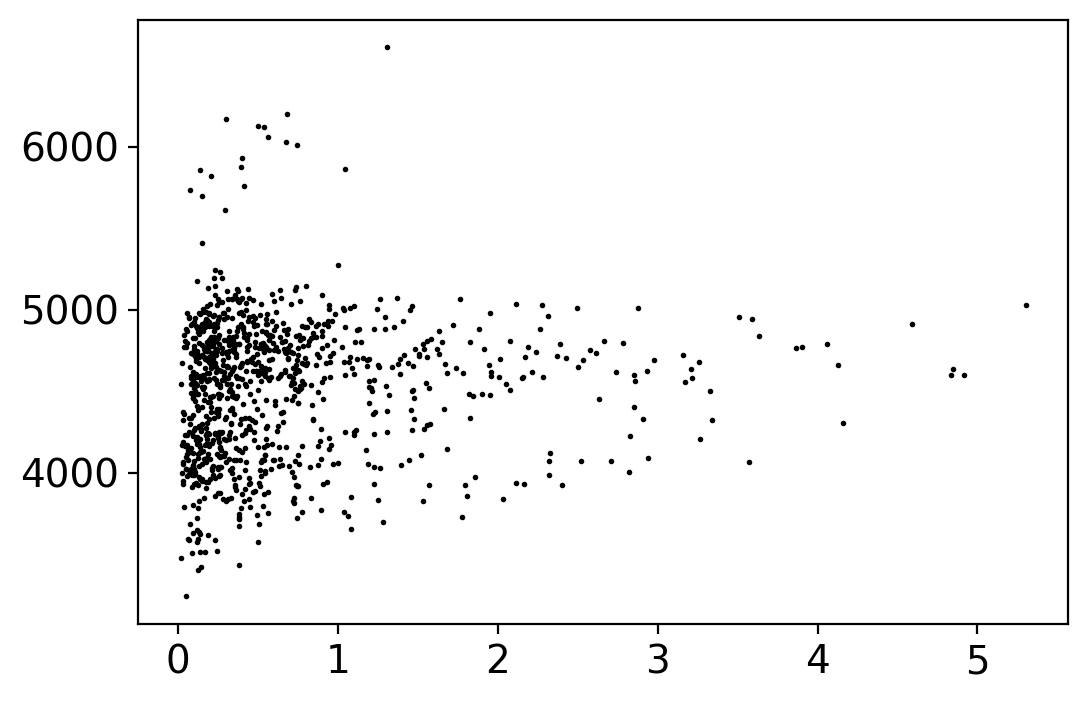

In [24]:
plt.scatter(x2_val[:,0], y_val, s=1, color="black")

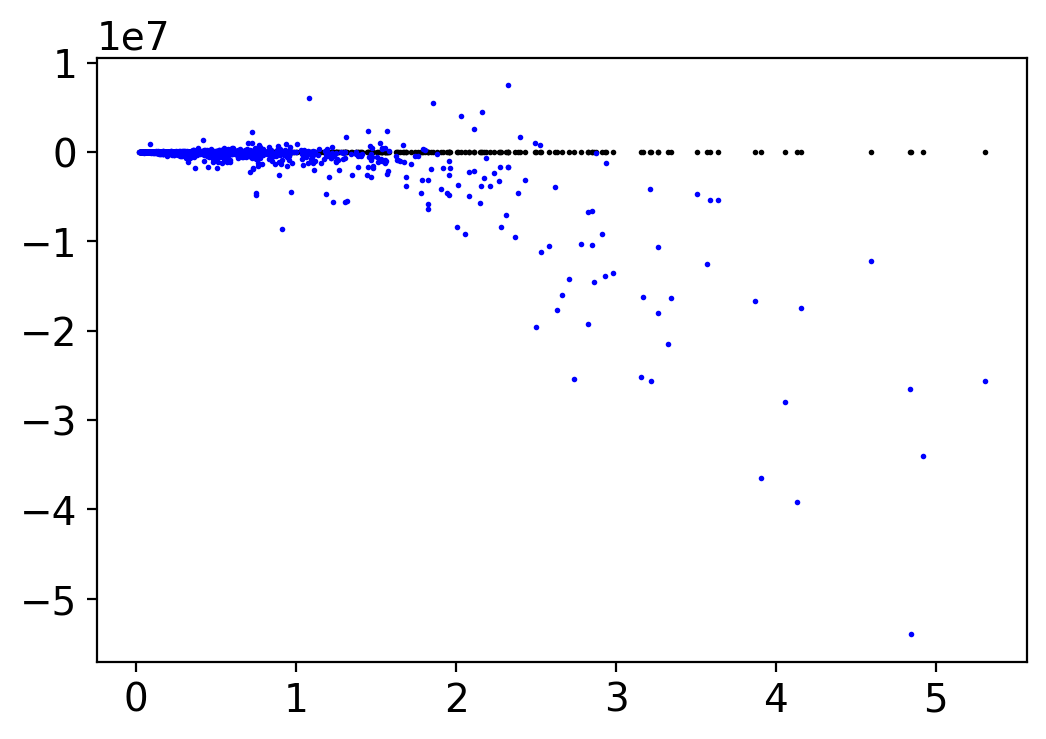

In [25]:
# Plot outputs
plt.scatter(x2_val[:,0], y_val, s=1, color="black")
#plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.scatter(x2_val[:,0], y_pred2, color="blue", s=1)
#plt.ylim(0, 10000)

#hmm thats worse

The polynomial regression yielded a higher coefficient of determination than multiple linear regression for the same problem for the training data (0.488 vs 0.877). A 𝑅² closer to 1 could be better, but a complex model and 𝑅² very close to one might also be a sign of overfitting. Testing this with the testing data, the linear and quadratic combination model is in fact worse than the linear regression. 

In [ ]:
#cubic just to try

x3_train = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_train_rp)
x3_val = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_val_rp)


print(x_train_rp.shape, x3_train.shape)
print(x_val_rp.shape, x3_val.shape)

model3 = LinearRegression().fit(x3_train, y_train)

In [28]:
r_c3 = model3.score(x3_train, y_train)
print(f"coefficient of determination for training: {r_c3}")

print(f"intercept: {model3.intercept_}")

# Make predictions using the testing set
y_pred3 = model3.predict(x3_val)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred3))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred3))

#cubic is an even worse overfit!!!

coefficient of determination for training: 1.0
intercept: 4333.268873878198
Mean squared error: 940564758006971.00
Coefficient of determination: -5192608794.79


**Problem 3:** Fit the famous data set 11 from Problem Set 2, but now with a single Gaussian Process. Choose as your kernel the Matern 3/2 kernel. Use the form of the GP regression shown in class, that involves both the kernel matrix K and the noise covariance C. Plot the GP result by evaluating the GP on a set of test locations which is a fine grid of spacing (say) 0.1 days over a footprint that goes from -50 days to 1075 days (ie, more than the span of the data). Plot the GP result for three different (but all reasonable) values for the Matern kernel width (the hyper-parameter). Bonus points: Plot not just the best-fit, but the uncertainty (variance) region around that fit, as per Rasmussen & Williams.

In [ ]:
with open("C:/Users/jessm/Documents/NYU/2nd Year/Data Analysis/data2.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

# Dear all:
# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)

t=data[0]
sigma=data[1]

y=data[-1]
plt.figure(figsize=(15, 5))
plt.plot(t, y, '.')
plt.errorbar(t, y, yerr=sigma, color="b", alpha=0.5)
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set 11")

print(t)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

X= t.reshape(-1, 1)
kernel = 1.0 * Matern(length_scale=10, nu=.5)

rng = np.random.RandomState(1)
#print(y.size)
training_indices = rng.choice(np.arange(y.size), size=100, replace=False)
#print(training_indices)
X_train, y_train = X[training_indices], y[training_indices]

gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

In [ ]:
print(t)
t_long=np.arange(-50,1075,0.01)
X_long= t_long.reshape(-1, 1)

#mean_prediction, std_prediction = gaussian_process.predict(X_long, return_std=True)
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(X_long, return_std=True)


plt.figure(figsize=(15, 5))
plt.plot(X, y, ".", label="observations")
plt.errorbar(t, y, yerr=sigma, color="b", alpha=0.5)
#plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_long, mean_predictions_gpr, 'r.', label="mean prediction")
plt.fill_between(
    X_long.ravel(),
    mean_predictions_gpr- (std_predictions_gpr**2),
    mean_predictions_gpr + std_predictions_gpr**2,
    alpha=0.5,
    label=r"variance",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian Process Regression on Dataset 11 using Matern .5")

In [ ]:
kernel = 1.0 * Matern(length_scale=1, nu=1.5)

gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(X_train, y_train)
print(gaussian_process.kernel_)

mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(X_long, return_std=True)


plt.figure(figsize=(15, 5))
plt.plot(X, y, ".", label="observations")
plt.errorbar(t, y, yerr=sigma, color="b", alpha=0.5)
#plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_long, mean_predictions_gpr, 'r.', label="Mean prediction")
plt.fill_between(
    X_long.ravel(),
    mean_predictions_gpr- (std_predictions_gpr**2),
    mean_predictions_gpr + std_predictions_gpr**2,
    alpha=0.5,
    label=r"variance",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian Process Regression on Dataset 11 using Matern 1.5")

In [ ]:
kernel = 1.0 * Matern(length_scale=.1, nu=2.5)

gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(X_train, y_train)
print(gaussian_process.kernel_)

mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(X_long, return_std=True)


plt.figure(figsize=(15, 5))
plt.plot(X, y, ".", label="observations")
#plt.scatter(X_train, y_train, label="Observations")
plt.errorbar(t, y, yerr=sigma, color="b", alpha=0.5)
plt.plot(X_long, mean_predictions_gpr, 'r.', label="Mean prediction")
plt.fill_between(
    X_long.ravel(),
    mean_predictions_gpr- (std_predictions_gpr**2),
    mean_predictions_gpr + std_predictions_gpr**2,
    alpha=0.5,
    label=r"variance",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian Process Regression on Dataset 11 using Matern 2.5")